# Importing Packages

# Pre-processing

## Remove rows with missing IC50

In [4]:
import pandas as pd
import numpy as np
import pickle

organism = 'Target Source Organism According to Curator or DataSource'
chain = 'BindingDB Target Chain Sequence'
multichain = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
cols = [organism, chain, multichain, 'Target Name', 'IC50 (nM)', 'Ligand SMILES', 'BindingDB Ligand Name', 'Ligand InChI Key']


path = r'BindingDB_BindingDB_Articles_202310.tsv'
df = pd.read_csv(path, delimiter='\t', usecols=range(50))
length_filter = df[chain].str.len() <= 1000                 # remove very long protein sequence

df = df[~df['IC50 (nM)'].isna() & length_filter][cols].drop_duplicates().reset_index(drop=True)
df = df.reset_index(drop=True)
df['is_viral_protein'] = df[organism].str.contains('virus')

df['IC50 (nM)'] = df['IC50 (nM)'].str.strip()

df['IC50_nM_cleaned'] = df['IC50 (nM)'].str.replace('[><]','', regex=True).astype(float)
df.loc[df['IC50 (nM)'].str.contains('>'), 'IC50_nM_cleaned'] = df[df['IC50 (nM)'].str.contains('>')]['IC50_nM_cleaned'] - 0.5

df['is_IC50_below_10_nM'] = df['IC50_nM_cleaned'] < 10
df['is_IC50_below_100_nM'] = df['IC50_nM_cleaned'] < 100

# df['Ki_nM_cleaned'] = df['Ki (nM)'].str.replace('[><]','', regex=True).astype(float)
# df.loc[df['Ki (nM)'].fillna('').str.contains('>'), 'Ki_nM_cleaned'] = df[df['Ki (nM)'].fillna('').str.contains('>')]['Ki_nM_cleaned'] - 0.5
df.to_csv('BindingDB_ligand_target_IC50_cleaned.csv', index=False)
df.head()

C:\Users\mdhya\AppData\Local\Temp\ipykernel_10304\2833636289.py:12: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter='\t', usecols=range(50))


,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,Number of Protein Chains in Target (>1 implies a multichain complex),Target Name,IC50 (nM),Ligand SMILES,BindingDB Ligand Name,Ligand InChI Key,is_viral_protein,IC50_nM_cleaned,is_IC50_below_10_nM,is_IC50_below_100_nM
0,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,8.7,COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)...,3-quinolinecarbonitrile 3::4-Phenylamino-3-qui...,MVQUQGLRQPMJPU-UHFFFAOYSA-N,NaN,8.7,True,True
1,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,5.1,COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1...,3-quinolinecarbonitrile 4::6-methoxy-7-[3-(4-m...,VOUVVBUKNLBXGS-UHFFFAOYSA-N,NaN,5.1,True,True
2,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,2.8,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1O...,"3-quinolinecarbonitrile 8::4-[(2,4-dichloro-5-...",VXEOIAFZWQMOEP-UHFFFAOYSA-N,NaN,2.8,True,True
3,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,12,COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC,"3-quinolinecarbonitrile 9::4-[(2,4-dichlorophe...",DTLASHUZTAPRBX-UHFFFAOYSA-N,NaN,12.0,False,True
4,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,25,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc...,"3-quinolinecarbonitrile 10::6,7-bis(2-methoxye...",BTBPPLGKNLXRGR-UHFFFAOYSA-N,NaN,25.0,False,True


In [4]:
df['is_IC50_above_1_nM'].value_counts()

is_IC50_above_1_nM
True     47721
False     1019
Name: count, dtype: int64

In [5]:
df['is_IC50_above_10_nM'].value_counts()

is_IC50_above_10_nM
True     43577
False     5163
Name: count, dtype: int64

## RdKit molecular descriptor

In [11]:
fp = pd.read_csv('morgan_fingerprints.csv')
fp_dict = {k:v for k,v in zip(fp['SMILES'], fp.iloc[:,2:].values)}
fp_dict

{'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc(Nc2c(cnc3cc(OCC4CCN(C)CC4)c(OC)cc23)C#N)c(Cl)cc1Cl': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCC1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=i

In [16]:

with open('morgan_fingerprints_nBits2048_radius3.pkl', 'wb') as f:
    pickle.dump(fp_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('morgan_fingerprints_nBits2048_radius3.pkl', 'rb') as f:
    fp_dict = pickle.load(f)
fp_dict

{'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc(Nc2c(cnc3cc(OCC4CCN(C)CC4)c(OC)cc23)C#N)c(Cl)cc1Cl': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCC1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=i

In [19]:
vA = fp_dict['Cc1[nH]c2ccccc2c1CCNCc1ccc(\C=C\C(=O)NO)cc1'] 
vB = fp_dict['Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1']

np.dot(vA,vB) / (np.linalg.norm(vA) * np.linalg.norm(vB))

1.0

## UMAP of Morgan Fingerprints

In [32]:
from umap import UMAP 
from ligand_target import get_morgan_fp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

umap_red = UMAP(n_neighbors=100, n_components=2)

In [10]:
# get only ligands that were tested for IC50 against viral proteins
df = pd.read_csv('BindingDB_ligand_target_IC50_cleaned.csv')
virusDF = df[df.is_viral_protein==1]
virusDF_ligands = virusDF['Ligand SMILES'].unique()
len(virusDF_ligands)

3107

In [15]:
morgan_fps = get_morgan_fp(virusDF_ligands)
morgan_fps.shape

(3107, 2048)

In [16]:
morgan_fps_umap2 = umap_red.fit_transform(morgan_fps)
morgan_fps_umap2

array([[10.041987 , 13.914823 ],
       [10.147738 , 13.87161  ],
       [10.051615 , 13.898816 ],
       ...,
       [ 7.0258994,  7.059091 ],
       [ 6.121846 ,  6.9645863],
       [ 6.0818257,  6.9768763]], dtype=float32)

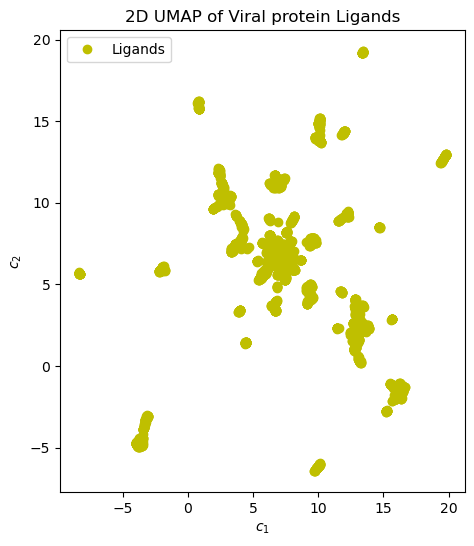

In [35]:
plt.figure(figsize = (12, 6))

plt.subplot(122)
plt.plot(morgan_fps_umap2[:, 0], morgan_fps_umap2[:, 1], 'yo', label = 'Ligands')
# plt.plot(X_95[:, 0][y_wine == 1], X_95[:, 1][y_wine == 1], 'bs', label = 'Cultivar 2')
# plt.plot(X_95[:, 0][y_wine == 2], X_95[:, 1][y_wine == 2], 'g^', label = 'Cultivar 3')
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Viral protein Ligands')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.show()

### Clustering

In [28]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from collections import Counter

clustering_algo = HDBSCAN(cluster_selection_epsilon=1)
clusters = clustering_algo.fit_predict(morgan_fps_umap2) 
clusters

array([ 8,  8,  8, ..., 21, 21, 21], dtype=int64)

In [30]:
cluster_stats = Counter(clusters)
cluster_stats

Counter({21: 826,
         20: 415,
         17: 375,
         1: 198,
         9: 163,
         8: 144,
         11: 142,
         18: 132,
         19: 99,
         15: 88,
         4: 79,
         3: 77,
         2: 71,
         6: 61,
         7: 47,
         0: 36,
         12: 33,
         5: 30,
         13: 29,
         16: 24,
         10: 22,
         14: 16})

C:\Users\mdhya\AppData\Local\Temp\ipykernel_10304\2170737295.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(morgan_fps_umap2[:, 0][clusters==cluster_num], morgan_fps_umap2[:, 1][clusters==cluster_num], 'yo', c=color_set[cluster_num], label = str(cluster_num))


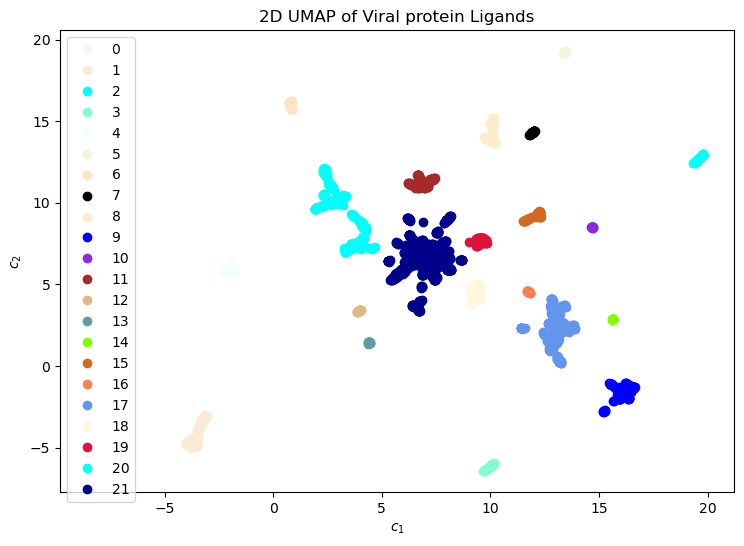

In [40]:
color_set = [x for x in mcolors.CSS4_COLORS.keys()]
plt.figure(figsize = (18, 6))

plt.subplot(122)
for cluster_num in range(max(clusters)+1):
    plt.plot(morgan_fps_umap2[:, 0][clusters==cluster_num], morgan_fps_umap2[:, 1][clusters==cluster_num], 'yo', c=color_set[cluster_num], label = str(cluster_num))

plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Viral protein Ligands')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.show()

## Augment Negative Example

In [55]:
chembl = pd.read_csv('CHEMBL_200_new.csv', sep = ';')
chembl = chembl.rename(columns={'Inchi Key':'Ligand InChI Key', 'Smiles':'Ligand SMILES'})
chembl = chembl[~chembl['Ligand InChI Key'].isin(df['Ligand InChI Key'].unique())]
chembl = chembl.drop_duplicates(subset='Ligand InChI Key').reset_index(drop=True)
chembl

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Ligand SMILES,Ligand InChI Key
0,CHEMBL1964670,NaN,NaN,Small molecule,NaN,132.16,53.0,53.0,0.32,46.53,...,9.0,3.0,1.0,0.0,132.0786,0.45,NEUTRAL,C6H12O3,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N
1,CHEMBL1162361,NaN,3-Fluoro-Pyridinium,Small molecule,NaN,97.09,1.0,1.0,1.22,12.89,...,7.0,1.0,0.0,0.0,97.0328,-2.20,NEUTRAL,C5H4FN,Fc1cccnc1,CELKOWQJPVJKIL-UHFFFAOYSA-N
2,CHEMBL4093989,NaN,NaN,Small molecule,NaN,179.22,1.0,3.0,1.57,52.32,...,13.0,3.0,2.0,0.0,179.0946,-1.14,NEUTRAL,C10H13NO2,CC(C)Oc1ccccc1C(N)=O,BTHLVVULQLRTBK-UHFFFAOYSA-N
3,CHEMBL1486321,NaN,NaN,Small molecule,NaN,118.14,2.0,2.0,-1.38,75.35,...,8.0,4.0,4.0,0.0,118.0742,1.31,ZWITTERION,C4H10N2O2,CNCC(N)C(=O)O,UJVHVMNGOZXSOZ-UHFFFAOYSA-N
4,CHEMBL1337040,NaN,NaN,Small molecule,NaN,178.57,4.0,5.0,-0.26,84.91,...,11.0,5.0,3.0,0.0,178.0145,0.61,ACID,C5H7ClN2O3,NC(C(=O)O)C1CC(Cl)=NO1,QAWIHIJWNYOLBE-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40300,CHEMBL160464,NaN,NaN,Small molecule,NaN,163.24,1.0,7.0,1.85,16.13,...,12.0,2.0,0.0,0.0,162.1157,-0.78,BASE,C10H14N2,[2H][C@H]1CC[C@@H](c2ccccn2)N1C,AQCRXZYYMOXFAN-AYZPNVOZSA-N
40301,CHEMBL1963329,NaN,NaN,Small molecule,NaN,190.25,NaN,NaN,1.56,35.64,...,14.0,4.0,0.0,0.0,190.1218,-1.20,NEUTRAL,C10H14N4,c1cn(CCCCn2ccnc2)cn1,LGCPYQSYWVJQCJ-UHFFFAOYSA-N
40302,CHEMBL2332208,NaN,NaN,Small molecule,NaN,195.24,1.0,1.0,1.73,16.38,...,14.0,2.0,0.0,0.0,195.1059,-1.40,NEUTRAL,C11H14FNO,C#CCN(C)[C@H](C[19F])Cc1ccco1,XBKZEROHOXZUGT-SOLGNKEASA-N
40303,CHEMBL3350386,NaN,NaN,Small molecule,NaN,130.14,1.0,2.0,0.15,57.53,...,9.0,3.0,2.0,0.0,128.0473,2.27,ACID,C6H8O3,[3H]C1(O)C=C(C(=O)O)CC1,VKJGQKRRULDFCI-XHHURNKPSA-N


In [54]:
proteins = df[chain].unique()
proteins

array(['MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL',
       'MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHTGICNQNIITYKNSTWVKDTTSVILTGNSSLCPIRGWAIYSKDNSIRIGSKGDVFVIREPFISCSHLECRTFFLTQGALLNDKHSNGTVKDRSPYRALMSCPVGEAPSPYNSRFESVAWSASACHDGMGWLTIGISGPDNGAVAVLKYNGIITETIKSWRKKILRTQESECACVNGSCFTIMTDGPSDGLASYKIFKIEKGKVTKSIELNAPNSHYEECSCYPDTGKVMCVCRDNWHGSNRPWVSFDQNLDYQIGYICSGVFGDNPRPEDGTGSCGPVYVDGANGVKGFSYRYGNGVWIGRTKSHSSRHGFEMIWDPNGWTETDSKFSVRQDVVAMTDWSGYSGSFVQHPELTGLDCMRPCFWVELIRGRPKEKTIWTSASSISFCGVNSDTVDWSWPDG

In [52]:
np.random.randint(low=0, high=chembl.shape[0], size=50000)

array([ 1564,  1491, 34732, ...,  2949, 16421,  9468])

In [59]:
from tqdm.notebook import tqdm

chembl_ligands_indices = np.random.randint(low=0, high=chembl.shape[0], size=50000)
protein_indices = np.random.randint(low=0, high=df[chain].nunique(), size=50000)

aug = []
for lidx, pidx in tqdm(zip(chembl_ligands_indices, protein_indices)):
    aug.append(
        {
            "Ligand SMILES":chembl['Ligand SMILES'].iloc[lidx],
            "Ligand InChI Key":chembl['Ligand InChI Key'].iloc[lidx],
            chain:df[chain].unique()[pidx]
        }
    )
augDF = pd.DataFrame(aug)
augDF

0it [00:00, ?it/s]

,Ligand SMILES,Ligand InChI Key,BindingDB Target Chain Sequence
0,NC(=O)NCc1ccccc1Cl,HHMVBUXOIGWQAQ-UHFFFAOYSA-N,MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVR...
1,CNC(=O)C1=CCC1,FBULOTIKUICNSL-UHFFFAOYSA-N,GSHMLETDMWIERTADITWESDAEITGSSERVDVRLDDDGNFQLMN...
2,S=C=NCc1ccc(Cl)cc1,DEHXIHUIYSXZNH-UHFFFAOYSA-N,MLISKSKMFKTFWILTSIVLLASATVDISKLQEFEEYQKFTNESLL...
3,CNC(=S)NN=C1NCCCN1,IOEZBJTXLLERBQ-UHFFFAOYSA-N,MWKRSEQMKIKSGKCNMAAAMETEQLGVEIFETADCEENIESQDRP...
4,CCn1cc(/C=N/O)[n+](C)c1,BXKDTGJLFKXBOI-XBXARRHUSA-O,QTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKT...
...,...,...,...
49995,CNC[C@H](O)c1ccccc1,ZCTYHONEGJTYQV-VIFPVBQESA-N,MEHKEVVLLLLLFLKSGQGEPLDDYVNTQGASLFSVTKKQLGAGSI...
49996,N/C(=N/c1ccc([N+](=O)[O-])cc1)NO,PZCMBYNETUEFHQ-UHFFFAOYSA-N,MTLGRRLACLFLACVLPALLLGGTALASEIVGGRRARPHAWPFMVS...
49997,C=CC[N+]1(C)C2CCC1CC(O)C2,SDNMXQHFYFCRPC-UHFFFAOYSA-N,MTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVR...
49998,CCN1C(=O)C2C(C1=O)[C@H]1CC[C@@H]2O1,GRFVWXQJEITYKK-XEDAXZNXSA-N,MAEDGEEAEFHFAALYISGQWPRLRADTDLQRLGSSAMAPSRKFFV...


In [60]:
augDF['is_IC50_above_1_nM'] = 0
augDF['is_IC50_above_10_nM'] = 0
augDF.to_csv('chembl_augmented_negative_samples.csv', index=False)
augDF

,Ligand SMILES,Ligand InChI Key,BindingDB Target Chain Sequence,is_IC50_above_1_nM,is_IC50_above_10_nM
0,NC(=O)NCc1ccccc1Cl,HHMVBUXOIGWQAQ-UHFFFAOYSA-N,MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVR...,0,0
1,CNC(=O)C1=CCC1,FBULOTIKUICNSL-UHFFFAOYSA-N,GSHMLETDMWIERTADITWESDAEITGSSERVDVRLDDDGNFQLMN...,0,0
2,S=C=NCc1ccc(Cl)cc1,DEHXIHUIYSXZNH-UHFFFAOYSA-N,MLISKSKMFKTFWILTSIVLLASATVDISKLQEFEEYQKFTNESLL...,0,0
3,CNC(=S)NN=C1NCCCN1,IOEZBJTXLLERBQ-UHFFFAOYSA-N,MWKRSEQMKIKSGKCNMAAAMETEQLGVEIFETADCEENIESQDRP...,0,0
4,CCn1cc(/C=N/O)[n+](C)c1,BXKDTGJLFKXBOI-XBXARRHUSA-O,QTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKT...,0,0
...,...,...,...,...,...
49995,CNC[C@H](O)c1ccccc1,ZCTYHONEGJTYQV-VIFPVBQESA-N,MEHKEVVLLLLLFLKSGQGEPLDDYVNTQGASLFSVTKKQLGAGSI...,0,0
49996,N/C(=N/c1ccc([N+](=O)[O-])cc1)NO,PZCMBYNETUEFHQ-UHFFFAOYSA-N,MTLGRRLACLFLACVLPALLLGGTALASEIVGGRRARPHAWPFMVS...,0,0
49997,C=CC[N+]1(C)C2CCC1CC(O)C2,SDNMXQHFYFCRPC-UHFFFAOYSA-N,MTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVR...,0,0
49998,CCN1C(=O)C2C(C1=O)[C@H]1CC[C@@H]2O1,GRFVWXQJEITYKK-XEDAXZNXSA-N,MAEDGEEAEFHFAALYISGQWPRLRADTDLQRLGSSAMAPSRKFFV...,0,0


# Load Dataset

In [4]:
import pandas as pd
import numpy as np

organism = 'Target Source Organism According to Curator or DataSource'
chain = 'BindingDB Target Chain Sequence'
multichain = 'Number of Protein Chains in Target (>1 implies a multichain complex)'

augDF = pd.read_csv('chembl_augmented_negative_samples.csv')
df = pd.read_csv('BindingDB_ligand_target_IC50_cleaned.csv')
df

,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,Number of Protein Chains in Target (>1 implies a multichain complex),Target Name,IC50 (nM),Ligand SMILES,BindingDB Ligand Name,Ligand InChI Key,is_viral_protein,IC50_nM_cleaned,is_IC50_above_1_nM,is_IC50_above_10_nM
0,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,8.7,COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)...,3-quinolinecarbonitrile 3::4-Phenylamino-3-qui...,MVQUQGLRQPMJPU-UHFFFAOYSA-N,NaN,8.7,True,False
1,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,5.1,COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1...,3-quinolinecarbonitrile 4::6-methoxy-7-[3-(4-m...,VOUVVBUKNLBXGS-UHFFFAOYSA-N,NaN,5.1,True,False
2,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,2.8,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1O...,"3-quinolinecarbonitrile 8::4-[(2,4-dichloro-5-...",VXEOIAFZWQMOEP-UHFFFAOYSA-N,NaN,2.8,True,False
3,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,12,COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC,"3-quinolinecarbonitrile 9::4-[(2,4-dichlorophe...",DTLASHUZTAPRBX-UHFFFAOYSA-N,NaN,12.0,True,True
4,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,25,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc...,"3-quinolinecarbonitrile 10::6,7-bis(2-methoxye...",BTBPPLGKNLXRGR-UHFFFAOYSA-N,NaN,25.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
48735,Homo sapiens,MRIEERKSQHLTGLTDEKVKAYLSLHPQVLDEFVSESVSAETVEKW...,1,"cAMP and cAMP-inhibited cGMP 3',5'-cyclic phos...",4778,Cn1ncc(C(=O)NCc2cccc(n2)C(F)(F)F)c1C(=O)Nc1ccn...,"Roche-Dataset for PDE10A, Compound 1157",COEANQLECDJUTQ-UHFFFAOYSA-N,False,4778.0,True,True
48736,Homo sapiens,MRIEERKSQHLTGLTDEKVKAYLSLHPQVLDEFVSESVSAETVEKW...,1,"cAMP and cAMP-inhibited cGMP 3',5'-cyclic phos...",10000,Cc1cc(C)n2nc(\C=C\c3nc(Br)nn3C)nc2n1,"Roche-Dataset for PDE10A, Compound 1158",CXZDMXCGKANPSE-SNAWJCMRSA-N,False,10000.0,True,True
48737,Homo sapiens,MRIEERKSQHLTGLTDEKVKAYLSLHPQVLDEFVSESVSAETVEKW...,1,"cAMP and cAMP-inhibited cGMP 3',5'-cyclic phos...",10000,Cc1cc(C)n2nc(CCc3ncnn3C)nc2n1,"Roche-Dataset for PDE10A, Compound 1159",ZXZWHWCEIKOCQT-UHFFFAOYSA-N,False,10000.0,True,True
48738,Homo sapiens,MRIEERKSQHLTGLTDEKVKAYLSLHPQVLDEFVSESVSAETVEKW...,1,"cAMP and cAMP-inhibited cGMP 3',5'-cyclic phos...",4286,Cc1cc(C)c2c(NC(=O)c3c(cnn3C)C(=O)N3CCC3)nn(C)c2n1,"Roche-Dataset for PDE10A, Compound 1160",QDMZAWSIANWWBU-UHFFFAOYSA-N,False,4286.0,True,True


# Create Train-Test Split

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import numpy as np

In [5]:
from viral_protein import esm_collate
from preprocessing import protein_ligand_Dataset

train_batch_size = 3
test_batch_size = 3

X_train, X_test, y_train, y_test = train_test_split(
                                                    np.arange(df.shape[0]), 
                                                    df['is_IC50_below_100_nM'].astype(float).values, 
                                                    stratify= df['is_IC50_below_100_nM'].astype(float).values,
                                                    test_size=0.25, 
                                                    random_state=87,
                                                    shuffle=True)

train_dataset = protein_ligand_Dataset(df['Ligand SMILES'][X_train].values, 
                                       df[chain][X_train].values, 
                                       y_train)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

aug_train_dataset = protein_ligand_Dataset(
                                        np.concatenate((df['Ligand SMILES'][X_train].values, augDF['Ligand SMILES'].values), axis=0), 
                                        np.concatenate((df[chain][X_train].values, augDF[chain].values), axis=0), 
                                        np.concatenate((y_train, np.zeros(augDF.shape[0])), axis=0)
                                    )
aug_train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)


test_dataset = protein_ligand_Dataset(df['Ligand SMILES'][X_test].values, 
                                       df[chain][X_test].values, 
                                       y_test)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

full_dataset = protein_ligand_Dataset(df['Ligand SMILES'].values, 
                                      df[chain].values, 
                                      df['is_IC50_below_100_nM'].astype(float).values)
full_loader = DataLoader(full_dataset, batch_size=test_batch_size)

# Build XGBoost model with morgan FP and ESM embeddings as input

In [ ]:
def prep

# Build Transformers Model (incorporating ESM)

In [1]:
from transformers import AutoTokenizer, EsmForSequenceClassification, EsmConfig
from transformers.models.esm.modeling_esm import EsmEncoder, EsmEmbeddings
import torch 
import torch.nn as nn
from preprocessing import get_tokenized_morgan_fp

In [2]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm_model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t12_35M_UR50D", num_labels=2)
device = "cuda" if torch.cuda.is_available() else "cpu"

def ligand_target_collate(sample):
    ligand, protein, label = sample
    protein_inputs = tokenizer(protein, return_tensors="pt", padding='max_length', max_length=1001)
    ligand_inputs = get_tokenized_morgan_fp(ligand, max_length=2048)
    return ligand_inputs, protein_inputs, label

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
class ligand_targetESM(nn.Module):
    def __init__(self, config:EsmConfig, esm_model:EsmForSequenceClassification):
        super().__init__()
        self.esmEmbeddings = esm_model.esm.embeddings
        self.ligandEmbeddings = nn.Embedding(num_embeddings=2048+1, embedding_dim=256, padding_idx=0)

        self.esmEncoder = EsmEncoder(config)
        self.head = esm_model.esm.contact_head
    
    def forward(self, ligand, ligand_mask, protein, protein_mask):
        ligand_emb = self.ligandEmbeddings(ligand)
        protein_emb = self.esmEmbeddings(protein)
        cat = torch.cat((ligand_emb, protein_emb))
        output = self.esmEncoder(cat)
        output = self.head(output)
        return output

In [4]:
config = EsmConfig(
    hidden_size=480
)
model = ligand_targetESM(config=config, esm_model=esm_model).to(device)
model

ligand_targetESM(
  (esmEmbeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 480, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 480, padding_idx=1)
  )
  (ligandEmbeddings): Embedding(2049, 256, padding_idx=0)
  (esmEncoder): EsmEncoder(
    (layer): ModuleList(
      (0-11): 12 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=480, out_features=480, bias=True)
            (key): Linear(in_features=480, out_features=480, bias=True)
            (value): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((480,), eps=1e-12, elementwise_affine=True)
        )
        (intermediate)

## Train

In [ ]:
def ligand_target_train(model, dataloader):
    model.train()
    model.to(device)
    epochs = 100
    total_loss = 0
    optim = torch.optim.AdamW(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        total_loss = 0
        for batch, labels in dataloader:
            optim.zero_grad()
            # input = batch.clone()
            inputs = tokenizer(batch, return_tensors="pt", padding='max_length', max_length=1001)
            # print(inputs, labels)

            loss = model(
                inputs['input_ids'].to(device), 
                inputs['attention_mask'].to(device), labels=labels.to(device)).loss # type: ignore
            total_loss += loss
            loss.backward()
            optim.step()
    
        # if (epoch+1)%40==0 or epoch==0:
        print("Epoch: {} -> loss: {}".format(epoch+1, total_loss/(len(dataloader))))